**Model Skeleton**

Click [here](https://docs.google.com/document/d/1v8xBxDOmItnDbMlbNnb4KsY-F7_jp1F9RJ-aIMr2KHA/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [1]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm
import os, subprocess


import os
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from PIL import Image
import pandas as pd
import re
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import struct
import numpy as np
from torch.nn.functional import pad
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter


# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# 0. Variables from your unzipping script
# These should match what you used for unzipping
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip' # Source ZIP on Drive
extract_dir = '/content/Patches_Apr27' # Local extraction directory

In [4]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [5]:
#Create train, test, and val lists

train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")

train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [35]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 10, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'sox10'
}

# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {CONFIG['local_image_folder']}") # Verify local path
if CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: sox10
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**Note** – the ```n_buckets``` input for our bucketing logic is not included in the CONFIG. You'll have to manually change it the code chunk where we create the boundaries and data loaders (see below in section 6). The default is just to keep ```n_buckets``` = number of batches.

**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [36]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [37]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [38]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=all_cases_for_scan,
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

# Ensure full_meta_df is not empty before proceeding
if full_meta_df.empty:
    print("❌ Metadata DataFrame is empty. Cannot proceed. Please check previous steps, especially the image path and scan.")
    # exit() # Or handle appropriately

🔍 Scanning /content/Patches_Apr27 for stain='sox10'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:01<00:00, 44663.69it/s]


✅ Built & saved 15614 rows to /content/metadata_full_scan_local_paths.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_066_match_1_sox10_patch79.png


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [39]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [40]:
# ─── TRANSFORMS (Adaptive Pooling Approach) ───────────────────────────
# These transforms are applied to individual images by the Dataset's __getitem__.

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Example augmentation
    #transforms.RandomRotation(15), # Example augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Example augmentation
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

eval_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [41]:
# --- Corrected PatchDataset Class ---
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        # THIS LINE MUST EXECUTE BEFORE you try to access self.samples
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

        # NOW it's safe to print the length of self.samples
        print(f"DEBUG: Dataset initialized with {len(self.samples)} total samples.")

    def __len__(self) -> int:
        return len(self.samples)
    def __getitem__(self, idx: int):
            # The IndexError traceback means this 'idx' is out of range for 'self.samples'
            # The primary fix for that is ensuring __len__ and __init__ are correct
            # This print will help verify if it's still being called with bad indices
            # print(f"DEBUG: __getitem__ called with idx = {idx}. len(self.samples) = {len(self.samples)}")

            # Ensure idx is within bounds. If this check triggers, the problem is in __len__ or DataLoader
            if not (0 <= idx < len(self.samples)):
                raise IndexError(f"__getitem__ called with invalid index {idx}. Valid range is [0, {len(self.samples)-1}]")

            path, label = self.samples[idx] # This is the line that errors

            try:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                cid = int(case_pat.search(os.path.basename(path)).group(1))
                return img, label, cid
            except Exception as e:
                # --- CRITICAL FIX HERE ---
                # DO NOT return None. Instead, log the error and re-raise it.
                # This will force the DataLoader to stop at the first genuinely problematic image file.
                print(f"ERROR: Failed to load or process image at index {idx} from path: '{path}'. Error: {e}")
                raise # Re-raise the exception to stop execution and debug the root cause

In [42]:
# --- Splitting metadata and creating datasets ---
# (Small modifications to handle potentially empty full_meta_df)
if not full_meta_df.empty:
    train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])].reset_index(drop=True)
    val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])].reset_index(drop=True)
    test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])].reset_index(drop=True)

    if train_meta.empty or val_meta.empty or test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
    val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
    test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(train_dataset)}")
    print(f"✅ Val patches: {len(val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error
    train_dataset, val_dataset, test_dataset = None, None, None

DEBUG: Dataset initialized with 8141 total samples.
DEBUG: Dataset initialized with 3054 total samples.
DEBUG: Dataset initialized with 3416 total samples.
✅ Train patches: 8141
✅ Val patches: 3054
✅ Test patches: 3416


**6) Data Loader and Helper Functions**


There are 3 code chunks for 3 different helper functions:
- BucketSampler: function behind our bucketing logic. It will group indices of similar-sized images together
- make_boundaries_for_buckets: will calculate and define the actual size boundaries for our batches
- collate_fn_pad: collate functions are used by the DataLoader object to group individual samples into a batch. Our custom function also performs the padding operation within each batch

**Bucketing logic**: Because we have to pad images up to the size of the largest image within each batch, we want to make sure that images within the same batch are of similar sizes. To do this, we will first calculate the total_number_of_batches that will be used per epoch (total images/batch size). Then we will separate the images by width into total_number_of_batches number of bins (e.g. if total_number_of_batches = 40, then there will be 40 bins). Then each of these bins will be a batch and sent separately to be trained on — thus images within the same batch are of very similar sizes and the amount of padding needed is very negligible).

In [43]:

# ─── HELPER: BUCKET BATCH SAMPLER ─────────────────────────────────────
# This Sampler is responsible for the "bucketing" logic.
# It groups indices of similar-sized images together.
class BucketBatchSampler(Sampler):
    """
    Samples batches by grouping indices into buckets based on data source sizes.
    Batches are created from indices within the same bucket.
    """
    def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True):
        """
        Args:
            data_source_sizes (list): List of sizes (e.g., max dimension after resize) for each item.
            batch_size (int): The desired batch size.
            boundaries (list): A sorted list of size thresholds defining the buckets.
                               An item with size S falls into bucket i if boundaries[i-1] < S <= boundaries[i].
            shuffle (bool): Whether to shuffle indices within buckets and the order of batches.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Create buckets based on boundaries
        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, size in enumerate(data_source_sizes):
            # Determine which bucket the size falls into
            bucket_num = sum(size > b for b in boundaries)
            bucket_indices[bucket_num].append(idx)

        self.batches = []
        # Create batches from indices within each bucket
        for bucket_num in sorted(bucket_indices.keys()):
            indices_in_bucket = bucket_indices[bucket_num]
            if self.shuffle:
                np.random.shuffle(indices_in_bucket)

            for i in range(0, len(indices_in_bucket), batch_size):
                batch = indices_in_bucket[i:i+batch_size]
                if len(batch) > 0:
                    self.batches.append(batch)

        if self.shuffle:
            np.random.shuffle(self.batches)

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

In [44]:
# ─── HELPER: MAKE BUCKET BOUNDARIES (Optimized for N Batches) ─────────
# This helper is used to calculate the boundaries for the buckets.
def make_boundaries_for_buckets(sizes, n_buckets):
    """
    Creates bucket boundaries such that the data is split into approximately
    n_buckets groups of equal size based on the sorted 'sizes'.
    Returns n_buckets - 1 boundaries.
    """
    #if not sizes or n_buckets <= 1:
    if sizes is None or len(sizes) == 0 or n_buckets <= 1:
        return []

    # Convert to pandas Series to use quantile/percentile efficiently
    sizes_series = pd.Series(sizes)
    total_items = len(sizes_series)
    boundaries = []

    # Calculate quantiles to define boundaries
    # We need n_buckets - 1 division points
    quantiles = [(i / n_buckets) for i in range(1, n_buckets)]

    # Calculate the boundary values using quantiles
    # Handle potential errors if quantile calculation fails (e.g., not enough unique sizes)
    try:
        bounds = sizes_series.quantile(quantiles).tolist()
    except Exception:
        # Fallback to simpler percentile calculation if quantile fails
        qs = [100 * i / n_buckets for i in range(1, n_buckets)]
        bounds = np.percentile(sizes, qs).tolist()


    # Ensure boundaries are unique, sorted, and integer
    return sorted(list(set(int(b) for b in bounds)))

In [45]:

import torch
import torchvision.transforms.functional as F_tv
import numpy as np # For potential other data processing, though not strictly needed here

def collate_fn_pad(batch):
    # Separate images, labels, and cids from the batch
    # batch is a list of (img_tensor, label, cid) tuples
    imgs = [item[0] for item in batch]
    lbls = [item[1] for item in batch]
    cids = [item[2] for item in batch]

    # --- Step 1: Determine the maximum height and width within the CURRENT BATCH ---
    max_h_batch = 0
    max_w_batch = 0

    # Iterate through all images in the current batch to find max dimensions
    for img_tensor in imgs:
        # img_tensor.shape is (C, H, W)
        h, w = img_tensor.shape[1], img_tensor.shape[2]
        if h > max_h_batch:
            max_h_batch = h
        if w > max_w_batch:
            max_w_batch = w

    # --- Step 2: Pad each image in the current batch to these determined max dimensions ---
    padded_imgs = []
    for img_tensor in imgs:
        h, w = img_tensor.shape[1], img_tensor.shape[2]

        # Calculate padding amounts for this specific image to reach batch's max_h_batch and max_w_batch
        # We'll pad to the bottom and right for simplicity (left/top padding can be added for centering)
        pad_h_bottom = max_h_batch - h
        pad_w_right = max_w_batch - w

        # The pad function expects padding_left, padding_top, padding_right, padding_bottom
        # For padding to bottom-right, padding_left and padding_top are 0
        padding_amounts = (0, 0, pad_w_right, pad_h_bottom)

        # Apply padding
        padded_img = F_tv.pad(img_tensor, padding_amounts, fill=0) # fill=0 for black padding, or use mean/median
        padded_imgs.append(padded_img)

    # --- Step 3: Stack the padded images ---
    # Now, all tensors in padded_imgs should have identical dimensions (C, max_h_batch, max_w_batch)
    # torch.stack will work correctly.
    return torch.stack(padded_imgs), torch.tensor(lbls, dtype=torch.long), torch.tensor(cids)


In [46]:
# --- Create Samplers and DataLoaders ---
# (Added checks for empty datasets/metadata before creating samplers/loaders)

# Helper function to get filtered meta based on dataset's samples
def get_filtered_meta_for_sampler(original_meta_df, dataset_samples):
    # Get the paths that are actually in the dataset's samples
    dataset_paths = {path for path, _ in dataset_samples}
    # Filter the original meta_df to only include those paths
    filtered_meta = original_meta_df[original_meta_df['path'].isin(dataset_paths)].reset_index(drop=True)
    return filtered_meta

# --- TRAIN LOADER ---
if train_dataset and not train_meta.empty and len(train_dataset) > 0:
    # Filter train_meta to match the actual samples in train_dataset
    # This ensures len(filtered_train_meta) == len(train_dataset)
    filtered_train_meta = get_filtered_meta_for_sampler(train_meta, train_dataset.samples)

    train_widths = pd.to_numeric(filtered_train_meta['width'], errors='coerce').fillna(-1).astype(int)
    train_widths = train_widths[train_widths != -1] # Filter out unknown dimensions for bucket boundaries

    if not train_widths.empty:
        train_boundaries = make_boundaries_for_buckets(train_widths.tolist(), n_buckets=max(1, int(len(train_dataset)/CONFIG['batch_size'])))
        # Pass the widths from the FILTERED meta for the sampler
        train_batch_sampler = BucketBatchSampler(
            train_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=train_boundaries
        )
        train_loader = DataLoader(
            train_dataset, pin_memory=True, num_workers=0,
            batch_sampler=train_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None # Or fallback to standard DataLoader
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if val_dataset and not val_meta.empty and len(val_dataset) > 0:
    filtered_val_meta = get_filtered_meta_for_sampler(val_meta, val_dataset.samples)
    val_widths = pd.to_numeric(filtered_val_meta['width'], errors='coerce').fillna(-1).astype(int)
    val_widths = val_widths[val_widths != -1]
    if not val_widths.empty:
        val_boundaries = make_boundaries_for_buckets(val_widths.tolist(), n_buckets=max(1, int(len(val_dataset)/CONFIG['batch_size'])))
        val_batch_sampler = BucketBatchSampler(
            val_widths.tolist(),
            batch_size=CONFIG['batch_size'],
            boundaries=val_boundaries
        )
        val_loader = DataLoader(
            val_dataset, pin_memory=True, num_workers=0,
            batch_sampler=val_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if test_dataset and not test_meta.empty and len(test_dataset) > 0:
    filtered_test_meta = get_filtered_meta_for_sampler(test_meta, test_dataset.samples)
    test_widths = pd.to_numeric(filtered_test_meta['width'], errors='coerce').fillna(-1).astype(int)
    test_widths = test_widths[test_widths != -1]
    if not test_widths.empty:
        test_boundaries = make_boundaries_for_buckets(test_widths.tolist(), n_buckets=max(1, int(len(test_dataset)/CONFIG['batch_size'])))
        test_batch_sampler = BucketBatchSampler(
            test_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=test_boundaries
        )
        test_loader = DataLoader(
            test_dataset, pin_memory=True, num_workers=0,
            batch_sampler=test_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None

✅ Train DataLoader created with 4211 batches.
✅ Validation DataLoader created with 1619 batches.
✅ Test DataLoader created with 1797 batches.


**Note** - be careful about the n_buckets input if you are using non-adaptive pooling layers in your model. The n_buckets parameter directly influences sizes of images being fed into the network, since the amount of padding varies based on distribution of image sizes in each bucket (and hence the resultant batches). If your model architecture has pooling layers with fixed kernel sizes, such as MaxPooling, you will have to be careful about what image sizes are fed into the network. This is not a problem with Adaptive Pooling since, as the name suggests, this layer adapts features such as kernel size in accordance to the desired output size.

**7) Data Visualization and Summary Statistics**

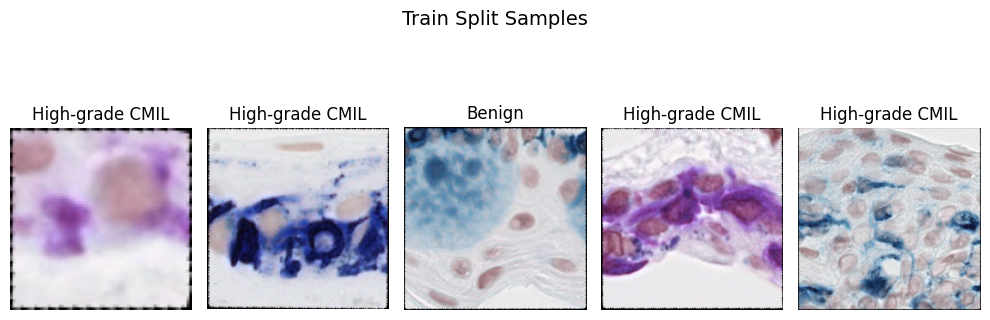


Train Set: Total Patches = 9705
  Benign (0):      4243
  High-grade (1):  5462

Validation Set: Total Patches = 3746
  Benign (0):      1104
  High-grade (1):  2642

Test Set: Total Patches = 4166
  Benign (0):      616
  High-grade (1):  3550


In [35]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [19]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler # Ensure autocast and GradScaler are imported
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess
from torch import nn, optim # Ensure nn and optim are imported
from torchvision import models # Ensure models is imported for AlexNet
from collections import Counter # Ensure Counter is imported for class weights


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for binary or multi-class classification.
        Args:
            gamma (float): Focusing parameter. When gamma > 0, easy examples are down-weighted.
                           A common value is 2.0.
            alpha (torch.Tensor, optional): A 1D tensor of weights for each class.
                                            Equivalent to `weight` in `nn.CrossEntropyLoss`.
                                            If None, no class weighting is applied via alpha.
            reduction (str): Specifies the reduction to apply to the output:
                             'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
                             'mean': the sum of the output will be divided by the number of
                             elements in the output, 'sum': the output will be summed.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha # This will be your class_weights_tensor
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs are logits (raw scores), targets are class indices
        # Cross-entropy loss (negative log-likelihood)
        # We pass self.alpha as 'weight' to F.cross_entropy to apply class weighting
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')

        # Get probabilities for the true class (pt)
        # torch.exp(-ce_loss) is a numerically stable way to get pt from ce_loss
        pt = torch.exp(-ce_loss)

        # Compute the modulating factor (1 - pt)^gamma
        focal_term = (1 - pt)**self.gamma

        # Apply the focal term to the cross-entropy loss
        loss = focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else: # 'none'
            return loss

In [21]:
import torch
import torch.nn as nn # Make sure to import torch.nn
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import os
import subprocess
import matplotlib.pyplot as plt
import gc # For garbage collection (already in your main script)

# Helper for moving batch to device (from your original code)
def move_batch_to_device(images, labels, device):
    """Moves a batch of images and labels to the specified device."""
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device, non_blocking=True) for img in images])
    else:
        images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    return images, labels

# ─── Training Function (Updated for Early Stopping, Mixed Precision, and Class Imbalance with FocalLoss support) ───────────────────
def train_model(
        model,
        optimizer,
        criterion_type, # This will now accept FocalLoss or nn.CrossEntropyLoss
        train_loader,
        val_loader,
        epochs=3,
        scheduler=None,
        resume_from=None,
        device=None,
        final_model_save_path=None,
        accumulation_steps=1,
        # Removed class_weights from this list of arguments, as it's now passed directly to criterion_type
        early_stopping_patience=None,
        focal_loss_gamma=2.0, # NEW: Gamma parameter for Focal Loss
        # IMPORTANT: If you want to use the class_weights_tensor directly with FocalLoss,
        # it needs to be accessible in this scope or passed here as a separate argument.
        # For this setup, we assume class_weights_tensor is accessible from the global scope
        # where train_model is called, or you explicitly pass it as an argument like `criterion_weights`.
        criterion_weights=None # NEW: Argument to pass weights to the criterion (e.g., alpha for FocalLoss)
    ):
    """
    Trains and evaluates a PyTorch model with gradient accumulation, mixed precision,
    and handles class imbalance using weighted loss, including memory management.
    Now includes early stopping based on validation loss and supports Focal Loss.

    Args:
        model (torch.nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): The optimizer for training.
        criterion_type (type): The class of the loss function (e.g., torch.nn.CrossEntropyLoss or FocalLoss).
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        epochs (int, optional): Number of training epochs. Defaults to 3.
        scheduler (torch.optim.lr_scheduler._LRScheduler, optional): Learning rate scheduler. Defaults to None.
        resume_from (str, optional): Path to a checkpoint file to resume training from. Defaults to None.
        device (torch.device, optional): The device to train on (e.g., 'cuda' or 'cpu').
                                          Defaults to None (auto-detects 'cuda' if available).
        final_model_save_path (str, optional): Path to save the final model weights after training completes.
                                                Defaults to None (no final save).
        accumulation_steps (int, optional): Number of batches to accumulate gradients over.
                                            Simulates a larger effective batch size. Defaults to 1 (no accumulation).
        early_stopping_patience (int, optional): Number of epochs to wait for an
                                                improvement in validation loss before stopping training.
                                                If None, early stopping is disabled. Defaults to None.
        focal_loss_gamma (float): Gamma parameter for Focal Loss. Only used if criterion_type is FocalLoss.
        criterion_weights (torch.Tensor, optional): A 1D tensor of weights for each class.
                                                If provided, it will be passed to the loss function's
                                                'weight' or 'alpha' parameter. Defaults to None.
    Returns:
        torch.nn.Module: The trained model.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    torch.backends.cudnn.benchmark = True
    model.to(device)

    # --- Initialize Criterion based on type ---
    # Convert weights to device if provided
    if criterion_weights is not None and not isinstance(criterion_weights, torch.Tensor):
        criterion_weights = torch.tensor(criterion_weights, dtype=torch.float32).to(device)
    elif criterion_weights is not None:
        criterion_weights = criterion_weights.to(device)

    if criterion_type == FocalLoss:
        criterion = criterion_type(gamma=focal_loss_gamma, alpha=criterion_weights)
        print(f"📊 Using Focal Loss (gamma={focal_loss_gamma}) with alpha weights: {criterion_weights.tolist() if criterion_weights is not None else 'None'}")
    elif criterion_type == nn.CrossEntropyLoss:
        criterion = criterion_type(weight=criterion_weights)
        print(f"📊 Using CrossEntropyLoss with weights: {criterion_weights.tolist() if criterion_weights is not None else 'None'}")
    else:
        # Fallback for other custom loss functions
        criterion = criterion_type()
        print(f"📊 Using custom loss criterion: {criterion_type.__name__}")

    scaler = GradScaler()
    model_dir = "/content/drive/MyDrive/melan"
    os.makedirs(model_dir, exist_ok=True)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = None

    start_epoch = 0

    if resume_from and os.path.exists(resume_from):
        try:
            checkpoint = torch.load(resume_from, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_loss = checkpoint.get('val_loss', float('inf'))
            print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with previous best validation loss {best_val_loss:.4f}")
        except Exception as e:
            print(f"❌ Error loading checkpoint from {resume_from}: {e}. Starting training from scratch.")
            start_epoch = 0
            best_val_loss = float('inf')

    train_losses, val_losses, val_accuracies = [], [], []

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        optimizer.zero_grad()

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for i, batch in enumerate(train_bar):
            if batch[0] is None:
                continue
            images, labels, _ = batch
            images, labels = move_batch_to_device(images, labels, device)

            with autocast(enabled=(device.type == 'cuda')):
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            train_bar.set_postfix(loss=running_loss / (i + 1))

        if (i + 1) % accumulation_steps != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        try:
            gpu_stats = subprocess.check_output([
                "nvidia-smi",
                "--query-gpu=utilization.gpu,utilization.memory,memory.used,memory.total",
                "--format=csv,nounits,noheader"
            ], stderr=subprocess.DEVNULL).decode("utf-8").strip()
            util, mem_util, used, total = [x.strip() for x in gpu_stats.split(',')]
            print(f"🔍 [GPU Util] GPU: {util}% | Mem: {mem_util}% ({used}/{total} MiB)")
        except Exception:
            print(f"🔍 [CUDA] Alloc: {torch.cuda.memory_allocated(device)/1024**2:.1f} MiB | "
                  f"Cached: {torch.cuda.memory_reserved(device)/1024**2:.1f} MiB")

        model.eval()
        validation_loss, correct, total_val_samples = 0.0, 0, 0

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Validating Epoch {e+1}/{epochs}", leave=True)
            for batch in val_bar:
                if batch[0] is None:
                    continue
                images, labels, _ = batch
                images, labels = move_batch_to_device(images, labels, device)

                with autocast(enabled=(device.type == 'cuda')):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                validation_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total_val_samples += labels.size(0)

                del images, labels, outputs, preds, loss
                gc.collect()

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        avg_val_loss = validation_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        val_accuracy = correct / total_val_samples if total_val_samples > 0 else 0.0
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.4f}.. "
            f"Val Loss: {avg_val_loss:.4f}.. "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"checkpoint_epoch_{e+1}.pth"))

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_path = os.path.join(model_dir, "best_model_val_loss.pth")
            torch.save(model.state_dict(), best_model_path)
            epochs_no_improve = 0
            print(f"✅ New best model (based on val_loss) saved at epoch {e+1} with loss {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in val_loss for {epochs_no_improve} epoch(s).")
            if early_stopping_patience is not None and epochs_no_improve >= early_stopping_patience:
                print(f"🛑 Early stopping triggered at epoch {e+1} due to no improvement in val_loss for {early_stopping_patience} consecutive epochs.")
                break

        if scheduler:
            if hasattr(scheduler, 'best'):
                 scheduler.step(avg_val_loss)
            else:
                 scheduler.step()

    epochs_trained = list(range(start_epoch + 1, e + 2 if e + 1 <= epochs else epochs + 1))
    if len(epochs_trained) == len(train_losses) and len(epochs_trained) > 0:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_trained, train_losses, label='Training Loss')
        plt.plot(epochs_trained, val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss During Training')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_trained, val_accuracies, label='Validation Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping plotting due to insufficient data or mismatch between epoch range and metric list lengths.")

    if best_model_path and os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"✨ Loaded best model weights from: {best_model_path}")
    else:
        print("❗ No best model was saved (e.g., due to early stopping with no improvement, or initial conditions). Returning last epoch's model.")

    if final_model_save_path:
        os.makedirs(os.path.dirname(final_model_save_path), exist_ok=True)
        torch.save(model.state_dict(), final_model_save_path)
        print(f"🎉 Final (likely best) model weights saved to: {final_model_save_path}")

    return model

**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want and modify feature extractor to include AdaptivePooling



```
# Modify feature extractor to include AdaptiveAvgPool2d
model.features = nn.Sequential(*list(model.features), nn.AdaptiveAvgPool2d((6, 6)))
in_ftrs = 256 * 6 * 6

# Custom classifier
model.classifier = nn.Sequential(
    nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
    nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
    nn.Linear(4096, 2)
)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F # For F.relu and F.adaptive_avg_pool2d
import torchvision.models as models # Needed for models.densenet121

# === Helper: Replace BatchNorm2d with GroupNorm ===
def replace_bn_with_gn(module, num_groups=32):
    """
    Recursively replaces all BatchNorm2d layers in a module with GroupNorm layers.
    This is often used for stability in certain training setups or when batch size is very small.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            # Ensure num_groups does not exceed num_channels
            setattr(module, name, nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

# === KimiaNet with GroupNorm and Dropout ===
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True, dropout_rate=0.25):
        """
        Initializes the KimiaNetClassifier model.

        Args:
            num_classes (int): The number of output classes for the classifier.
            use_groupnorm (bool): If True, replaces BatchNorm2d layers in the base DenseNet
                                  with GroupNorm layers.
            dropout_rate (float): The dropout probability to apply before the final
                                  classification layer. A value of 0 means no dropout.
        """
        super(KimiaNetClassifier, self).__init__()

        # Load the base DenseNet121 model
        # pretrained=False because KimiaNet uses specific weights that are loaded later
        base = models.densenet121(pretrained=False)

        # Optionally replace BatchNorm with GroupNorm in the base feature extractor
        if use_groupnorm:
            replace_bn_with_gn(base)

        # The feature extraction part of DenseNet
        self.features = base.features

        # Add a Dropout layer
        # This will be applied to the flattened features before the final classifier
        self.dropout = nn.Dropout(p=dropout_rate)

        # The final classification layer
        # DenseNet121's classifier input features is 1024
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the model.
        """
        # Pass input through the DenseNet feature extractor
        x = self.features(x)

        # Apply ReLU activation (as in original KimiaNet implementation)
        x = F.relu(x, inplace=True)

        # Apply adaptive average pooling to reduce spatial dimensions to 1x1
        # Then flatten the tensor for the linear classifier
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)

        # Apply dropout to the flattened features
        x = self.dropout(x)

        # Pass through the final classification layer
        return self.classifier(x)

# === Setup ===
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model with a specified dropout rate (e.g., 0.5)
# You can adjust this value based on experimentation.
# Common dropout rates are between 0.2 and 0.5.
model = KimiaNetClassifier(num_classes=2, dropout_rate=0.25).to(device)

# Load weights (skip classifier mismatch if loading a pre-trained feature extractor)
# Ensure the path to your weights is correct
kimianet_weights_path = '/content/drive/MyDrive/KimiaNetPyTorchWeights.pth'
if os.path.exists(kimianet_weights_path):
    state_dict = torch.load(kimianet_weights_path, map_location=device)
    # Filter out the 'classifier' weights from the loaded state_dict
    # because our new classifier layer needs to be initialized differently
    filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
    # Load the filtered state dict, allowing for non-matching keys (like the new classifier and dropout)
    model.load_state_dict(filtered_state_dict, strict=False)
    print(f"✅ Loaded KimiaNet weights from {kimianet_weights_path} (classifier layer skipped).")
else:
    print(f"❌ Warning: KimiaNet weights not found at {kimianet_weights_path}. Model will use random initialization for base features.")


# Define your loss criterion
criterion = nn.CrossEntropyLoss()

# Define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Loaded KimiaNet weights from /content/drive/MyDrive/KimiaNetPyTorchWeights.pth (classifier layer skipped).


In [23]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',      # Monitor validation loss (minimize)
    factor=0.25,      # Reduce learning rate by 10%
    patience=3,      # Wait 5 epochs of no improvement in val_loss before reducing LR
    verbose=True,
    min_lr=1e-6      # Minimum learning rate
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import torch.nn as nn # Make sure this import is present
import torch

# Assuming the FocalLoss class is defined elsewhere in your script (as provided above)

# Counts for class_0 and class_1
count_class_0 = 4243
count_class_1 = 5462

# Calculate weights: higher weight for the minority class (class 0)
# Weight for class 1 (majority) = 1.0
weight_for_class_0 = count_class_1 / count_class_0 # 5400 / 4200 approx 1.2857

# This class_weights_tensor will now be passed as 'alpha' to FocalLoss
class_weights_tensor = torch.tensor([weight_for_class_0*2, 1.0], dtype=torch.float32)

# train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion_type=FocalLoss, # <--- CHANGE THIS to FocalLoss
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=scheduler,
    resume_from=None,
    final_model_save_path="/content/drive/MyDrive/melan/final_trained_model_3.pth",

    device=CONFIG['device'],
    # class_weights=class_weights_tensor, # <--- REMOVE THIS, as it's now handled by criterion_weights
    early_stopping_patience=5,
    focal_loss_gamma=2.0, # <--- ADD THIS parameter for Focal Loss's gamma
    criterion_weights=class_weights_tensor # <--- ADD THIS to pass weights to the criterion
)

<ipython-input-21-5d53f6c1a634>:96: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


📊 Using Focal Loss (gamma=2.0) with alpha weights: [2.5745935440063477, 1.0]


Epoch 1/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 1/10: 100%|██████████| 4976/4976 [17:20<00:00,  4.78it/s, loss=0.295]


🔍 [GPU Util] GPU: 18% | Mem: 1% (763/40960 MiB)


Validating Epoch 1/10:   0%|          | 0/1963 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Validating Epoch 1/10: 100%|██████████| 1963/1963 [08:34<00:00,  3.81it/s]


Epoch: 1/10.. Train Loss: 0.2950.. Val Loss: 0.4670.. Val Accuracy: 0.6009
✅ New best model (based on val_loss) saved at epoch 1 with loss 0.4670


Epoch 2/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 2/10: 100%|██████████| 4976/4976 [16:28<00:00,  5.03it/s, loss=0.226]


🔍 [GPU Util] GPU: 25% | Mem: 1% (765/40960 MiB)


Validating Epoch 2/10:   0%|          | 0/1963 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Validating Epoch 2/10: 100%|██████████| 1963/1963 [08:35<00:00,  3.80it/s]


Epoch: 2/10.. Train Loss: 0.2264.. Val Loss: 0.4829.. Val Accuracy: 0.7058
No improvement in val_loss for 1 epoch(s).


Epoch 3/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 3/10: 100%|██████████| 4976/4976 [16:28<00:00,  5.03it/s, loss=0.187]


🔍 [GPU Util] GPU: 27% | Mem: 1% (765/40960 MiB)


Validating Epoch 3/10:   0%|          | 0/1963 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Validating Epoch 3/10: 100%|██████████| 1963/1963 [08:35<00:00,  3.81it/s]


Epoch: 3/10.. Train Loss: 0.1867.. Val Loss: 0.6176.. Val Accuracy: 0.7421
No improvement in val_loss for 2 epoch(s).


Epoch 4/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 4/10: 100%|██████████| 4976/4976 [16:22<00:00,  5.07it/s, loss=0.162]


🔍 [GPU Util] GPU: 24% | Mem: 1% (765/40960 MiB)


Validating Epoch 4/10:   0%|          | 0/1963 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Validating Epoch 4/10: 100%|██████████| 1963/1963 [08:36<00:00,  3.80it/s]


Epoch: 4/10.. Train Loss: 0.1625.. Val Loss: 0.5187.. Val Accuracy: 0.7341
No improvement in val_loss for 3 epoch(s).


Epoch 5/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 5/10: 100%|██████████| 4976/4976 [16:25<00:00,  5.05it/s, loss=0.149]


🔍 [GPU Util] GPU: 25% | Mem: 1% (765/40960 MiB)


Validating Epoch 5/10:   0%|          | 0/1963 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:182: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Validating Epoch 5/10: 100%|██████████| 1963/1963 [08:36<00:00,  3.80it/s]


Epoch: 5/10.. Train Loss: 0.1488.. Val Loss: 0.5162.. Val Accuracy: 0.7392
No improvement in val_loss for 4 epoch(s).


Epoch 6/10:   0%|          | 0/4976 [00:00<?, ?it/s]<ipython-input-21-5d53f6c1a634>:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):
Epoch 6/10:  69%|██████▊   | 3411/4976 [11:02<02:46,  9.40it/s, loss=0.11]

**9. Model Evaluation**

In [2]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


NameError: name 'trained_model' is not defined

**Adding Threshold Sweep**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Attempting to evaluate model from: /content/drive/MyDrive/melan/sox10_best_model.pth
✅ Model weights loaded successfully from: /content/drive/MyDrive/melan/sox10_best_model.pth

=== Test Set Performance (Default Threshold) ===
Accuracy      : 0.7207
Precision     : 0.9305
Recall        : 0.7058
F1 Score      : 0.8027

Classification Report (Default Threshold):
                 precision    recall  f1-score   support

         Benign       0.39      0.78      0.52       666
High-grade CMIL       0.93      0.71      0.80      2750

       accuracy                           0.72      3416
      macro avg       0.66      0.74      0.66      3416
   weighted avg       0.83      0.72      0.75      3416



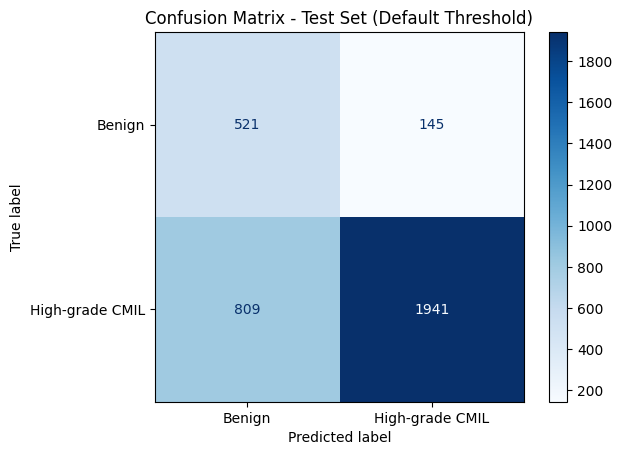


--- Starting Threshold Sweep ---
Sweeping thresholds for 'Benign' (Class 0)...


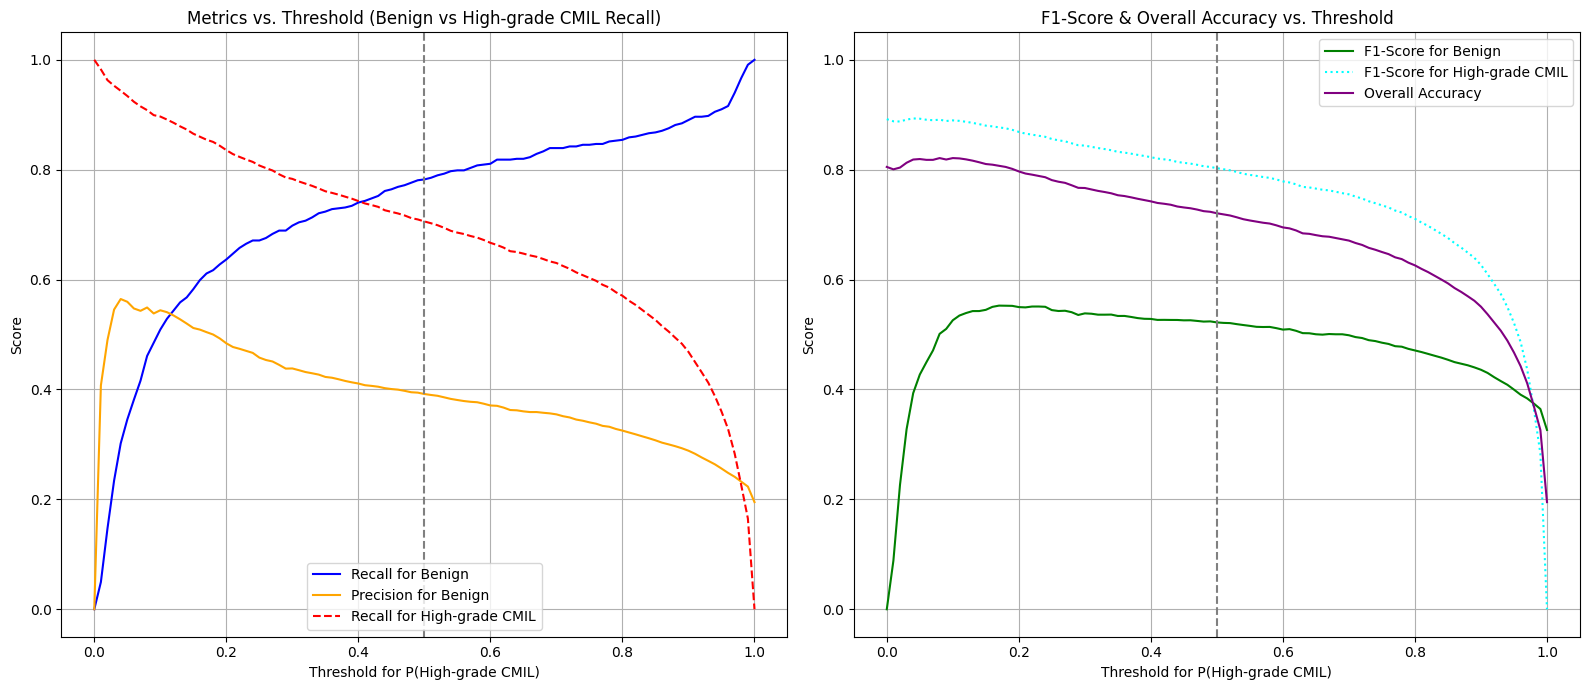


Threshold Sweep Results (first 5 rows):
   Threshold  Precision    Recall  F1-Score  High-grade CMIL Precision  \
0       0.00   0.000000  0.000000  0.000000                   0.805035   
1       0.01   0.407407  0.049550  0.088353                   0.810195   
2       0.02   0.490000  0.147147  0.226328                   0.823383   
3       0.03   0.545455  0.234234  0.327731                   0.837061   
4       0.04   0.564607  0.301802  0.393346                   0.848039   

   High-grade CMIL Recall  High-grade CMIL F1-Score  Overall Accuracy  
0                1.000000                  0.891988          0.805035  
1                0.982545                  0.888085          0.800644  
2                0.962909                  0.887697          0.803864  
3                0.952727                  0.891156          0.812646  
4                0.943636                  0.893287          0.818501  

Threshold Sweep Results (last 5 rows):
     Threshold  Precision    Recall  F1-Sc

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Needed for KimiaNetClassifier
import torchvision.models as models # Needed for models.densenet121
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os # For checking if model_path exists

# === Helper: Replace BatchNorm2d with GroupNorm ===
# This helper is necessary because KimiaNetClassifier uses it
def replace_bn_with_gn(module, num_groups=32):
    """
    Recursively replaces all BatchNorm2d layers in a module with GroupNorm layers.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            setattr(module, name, nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

# === KimiaNetClassifier definition ===
# This class definition is crucial to instantiate the model architecture
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True, dropout_rate=0.25):
        super(KimiaNetClassifier, self).__init__()
        base = models.densenet121(pretrained=False)
        if use_groupnorm:
            replace_bn_with_gn(base)
        self.features = base.features
        self.dropout = nn.Dropout(p=dropout_rate) # Dropout needs to be defined in the model
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.dropout(x) # Apply dropout during evaluation, it will be skipped by model.eval()
        return self.classifier(x)


# --- Threshold Sweeper Function (re-included and updated) ---
def sweep_thresholds(
    y_true: np.ndarray,
    y_pred_proba: np.ndarray,
    target_class_label: int,
    class_names: list[str],
    thresholds: np.ndarray = np.arange(0.0, 1.01, 0.01),
    positive_class_index: int = 1
) -> pd.DataFrame:
    """
    Sweeps through a range of prediction thresholds to evaluate classification metrics.

    This function is particularly useful for imbalanced datasets to find an optimal
    threshold that balances precision and recall for a specific target class.
    It now also includes metrics for the 'other' class (High-grade CMIL) in the output.

    Args:
        y_true (np.ndarray): Array of true (ground truth) labels.
                             Labels should be integers (e.g., 0, 1).
        y_pred_proba (np.ndarray): Array of predicted probabilities, typically
                                   output from a model's predict_proba method.
                                   Shape should be (n_samples, n_classes).
        target_class_label (int): The integer label of the class for which
                                  you want to optimize recall (e.g., 0 for 'Benign').
        class_names (list[str]): A list of string names for your classes,
                                 ordered by their integer labels (e.g., ['Benign', 'High-grade CMIL']).
        thresholds (np.ndarray): A numpy array of thresholds to test. Defaults
                                 to a range from 0.0 to 1.0 in steps of 0.01.
        positive_class_index (int): The index in y_pred_proba that corresponds to the
                                    probability of the 'positive' class. The threshold
                                    will be applied to these probabilities.
                                    For example, if y_pred_proba[:, 1] contains
                                    probabilities for 'High-grade CMIL' and you want
                                    to make it harder to predict 'High-grade CMIL'
                                    (thereby increasing 'Benign' predictions),
                                    you'd set this to 1 and increase the threshold.

    Returns:
        pd.DataFrame: A DataFrame containing precision, recall, f1-score, and
                      accuracy for BOTH classes at each threshold.
    """

    results = []
    if not (0 <= target_class_label < len(class_names)):
        print(f"Error: target_class_label {target_class_label} is out of bounds for class_names with {len(class_names)} classes.")
        return pd.DataFrame()

    other_class_label = 1 if target_class_label == 0 else 0

    print(f"Sweeping thresholds for '{class_names[target_class_label]}' (Class {target_class_label})...")

    prob_to_threshold = y_pred_proba[:, positive_class_index]

    for t in thresholds:
        y_pred = (prob_to_threshold >= t).astype(int)

        unique_true = np.unique(y_true)
        unique_pred = np.unique(y_pred)
        labels_for_report = sorted(list(set(unique_true) | set(unique_pred) | set([0, 1])))
        if len(labels_for_report) > 2:
             labels_for_report = [0, 1]


        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=labels_for_report, target_names=class_names)

        current_row = {'Threshold': t}

        target_class_str = class_names[target_class_label]
        if target_class_str in report:
            metrics = report[target_class_str]
            current_row.update({
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
            })
        else:
            print(f"  Warning: Metrics for target class '{target_class_str}' not found for threshold {t}. Setting to NaN.")
            current_row.update({
                'Precision': np.nan, 'Recall': np.nan, 'F1-Score': np.nan
            })

        other_class_str = class_names[other_class_label]
        if other_class_str in report:
            metrics_other = report[other_class_str]
            current_row.update({
                f'{other_class_str} Precision': metrics_other['precision'],
                f'{other_class_str} Recall': metrics_other['recall'],
                f'{other_class_str} F1-Score': metrics_other['f1-score'],
            })
        else:
            print(f"  Warning: Metrics for class '{other_class_str}' not found for threshold {t}. Setting to NaN.")
            current_row.update({
                f'{other_class_str} Precision': np.nan, f'{other_class_str} Recall': np.nan, f'{other_class_str} F1-Score': np.nan
            })

        current_row['Overall Accuracy'] = accuracy_score(y_true, y_pred)
        results.append(current_row)

    results_df = pd.DataFrame(results)

    # --- Plotting the results ---
    plt.figure(figsize=(16, 7))

    plt.subplot(1, 2, 1)
    plt.plot(results_df['Threshold'], results_df['Recall'], label=f'Recall for {class_names[target_class_label]}', color='blue')
    plt.plot(results_df['Threshold'], results_df['Precision'], label=f'Precision for {class_names[target_class_label]}', color='orange')
    plt.plot(results_df['Threshold'], results_df[f'{class_names[other_class_label]} Recall'], label=f'Recall for {class_names[other_class_label]}', color='red', linestyle='--')

    plt.xlabel(f'Threshold for P({class_names[positive_class_index]})')
    plt.ylabel('Score')
    plt.title(f'Metrics vs. Threshold ({class_names[target_class_label]} vs {class_names[other_class_label]} Recall)')
    plt.grid(True)
    plt.legend()
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.ylim(-0.05, 1.05)


    plt.subplot(1, 2, 2)
    plt.plot(results_df['Threshold'], results_df['F1-Score'], label=f'F1-Score for {class_names[target_class_label]}', color='green')
    plt.plot(results_df['Threshold'], results_df[f'{class_names[other_class_label]} F1-Score'], label=f'F1-Score for {class_names[other_class_label]}', color='cyan', linestyle=':')
    plt.plot(results_df['Threshold'], results_df['Overall Accuracy'], label='Overall Accuracy', color='purple', linestyle='-')
    plt.xlabel(f'Threshold for P({class_names[positive_class_index]})')
    plt.ylabel('Score')
    plt.title(f'F1-Score & Overall Accuracy vs. Threshold')
    plt.grid(True)
    plt.legend()
    plt.axvline(x=0.5, color='gray', linestyle='--', label='Default Threshold (0.5)')
    plt.ylim(-0.05, 1.05)


    plt.tight_layout()
    plt.show()

    return results_df


# --- MODIFIED evaluate_model_on_test function (re-includes threshold sweep) ---
def evaluate_model_on_test(model, test_loader, device, model_path=None):
    """
    Evaluates a PyTorch model on the test set, with optional loading from a .pth file,
    and performs a threshold sweep.

    Args:
        model (torch.nn.Module): The model instance (should be initialized to match the saved state_dict's architecture).
        test_loader (torch.utils.data.DataLoader): DataLoader for test data.
        device (torch.device): The device to evaluate on ('cuda' or 'cpu').
        model_path (str, optional): Path to the .pth file containing the model's state_dict.
                                    If None, the `model` object passed is used as is.
    Returns:
        pd.DataFrame: A DataFrame containing the threshold sweep results.
    """
    # Load model weights if a path is provided
    if model_path:
        if os.path.exists(model_path):
            try:
                # Load only the model's state_dict
                model.load_state_dict(torch.load(model_path, map_location=device))
                print(f"✅ Model weights loaded successfully from: {model_path}")
            except Exception as e:
                print(f"❌ Error loading model weights from {model_path}: {e}")
                print("Proceeding with the model's current (possibly random) weights.")
        else:
            print(f"❌ Warning: Model file not found at {model_path}. Proceeding with current model weights.")

    model.eval() # Set model to evaluation mode
    model.to(device) # Ensure model is on the correct device

    all_preds = []
    all_labels = []
    all_pred_proba = [] # Will store probabilities for threshold sweep

    softmax = nn.Softmax(dim=1) # Softmax to get probabilities from logits

    with torch.no_grad():
        for images, labels, _ in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1) # Get hard predictions for initial report
            probabilities = softmax(outputs) # Get probabilities for threshold sweep

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_pred_proba.extend(probabilities.cpu().numpy()) # Store probabilities

    all_labels = np.array(all_labels) # Ensure labels are numpy array for sklearn
    all_pred_proba = np.array(all_pred_proba) # Convert list of probabilities to numpy array

    # === Compute Metrics for default threshold (0.5) ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print("\n=== Test Set Performance (Default Threshold) ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report (Default Threshold):")
    class_names = ["Benign", "High-grade CMIL"]
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set (Default Threshold)")
    plt.show()

    # --- Start Threshold Sweep ---
    print("\n--- Starting Threshold Sweep ---")
    threshold_results_df = sweep_thresholds(
        y_true=all_labels,
        y_pred_proba=all_pred_proba,
        target_class_label=0, # 'Benign' class label
        class_names=class_names,
        positive_class_index=1 # Index of 'High-grade CMIL' in y_pred_proba for thresholding
    )

    print("\nThreshold Sweep Results (first 5 rows):")
    print(threshold_results_df.head())
    print("\nThreshold Sweep Results (last 5 rows):")
    print(threshold_results_df.tail())

    if not threshold_results_df.empty:
        max_benign_recall_row = threshold_results_df.loc[threshold_results_df['Recall'].idxmax()]
        print(f"\nOptimal Threshold for Maximizing Benign Recall:")
        print(f"  Threshold (P(High-grade CMIL)): {max_benign_recall_row['Threshold']:.2f}")
        print(f"  Benign Recall: {max_benign_recall_row['Recall']:.4f}")
        print(f"  Benign Precision: {max_benign_recall_row['Precision']:.4f}")
        print(f"  Benign F1-Score: {max_benign_recall_row['F1-Score']:.4f}")
        print(f"  High-grade CMIL Recall: {max_benign_recall_row[f'{class_names[1]} Recall']:.4f}")
        print(f"  Overall Accuracy: {max_benign_recall_row['Overall Accuracy']:.4f}")
    else:
        print("\nNo threshold sweep results to analyze.")

    return threshold_results_df


# --- Dummy Dataset and DataLoader for Demonstration ---
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples, img_size=(3, 224, 224), num_classes=2, imbalance_ratio=0.1):
        self.num_samples = num_samples
        self.img_size = img_size
        self.num_classes = num_classes

        num_minority = int(num_samples * imbalance_ratio)
        num_majority = num_samples - num_minority

        minority_data = torch.randn(num_minority, *img_size) * 0.1 + 0.5
        majority_data = torch.randn(num_majority, *img_size) * 0.1 + 1.5

        minority_labels = torch.zeros(num_minority, dtype=torch.long)
        majority_labels = torch.ones(num_majority, dtype=torch.long)

        self.data = torch.cat((minority_data, majority_data), dim=0)
        self.labels = torch.cat((minority_labels, majority_labels), dim=0)
        self.case_ids = [f'case_{i}' for i in range(num_samples)]

        permutation = torch.randperm(num_samples)
        self.data = self.data[permutation]
        self.labels = self.labels[permutation]
        self.case_ids = [self.case_ids[i] for i in permutation]


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.case_ids[idx]

# --- Setup for Model Loading and Evaluation ---
CONFIG = {
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'batch_size': 2,
    'dropout_rate': 0 # This must match the dropout rate used during training if loading an exact model
}

# 1. Instantiate the model architecture
model_architecture = KimiaNetClassifier(
    num_classes=2,
    dropout_rate=CONFIG['dropout_rate'], # Ensure this matches your trained model's dropout
    use_groupnorm=True
).to(CONFIG['device'])

# 2. Define the path to your .pth file
# IMPORTANT: Replace this with the actual path to your SAVED MODEL WEIGHTS
your_trained_model_path = "/content/drive/MyDrive/melan/sox10_best_model.pth"
# Or, if you want to evaluate the best model based on validation loss during training:
# your_trained_model_path = "/content/drive/MyDrive/melan/best_model_val_loss.pth"

# === Run Evaluation ===
print(f"Attempting to evaluate model from: {your_trained_model_path}")
threshold_df = evaluate_model_on_test(
    model=model_architecture, # Pass the instantiated model architecture
    test_loader=test_loader,
    device=CONFIG['device'],
    model_path=your_trained_model_path # Pass the path to load the weights from
)

print("\nEvaluation process completed.")

In [48]:
threshold_df.head(50)

,Threshold,Precision,Recall,F1-Score,High-grade CMIL Precision,High-grade CMIL Recall,High-grade CMIL F1-Score,Overall Accuracy
0,0.00,0.000000,0.000000,0.000000,0.805035,1.000000,0.891988,0.805035
1,0.01,0.407407,0.049550,0.088353,0.810195,0.982545,0.888085,0.800644
2,0.02,0.490000,0.147147,0.226328,0.823383,0.962909,0.887697,0.803864
3,0.03,0.545455,0.234234,0.327731,0.837061,0.952727,0.891156,0.812646
4,0.04,0.564607,0.301802,0.393346,0.848039,0.943636,0.893287,0.818501
5,0.05,0.559611,0.345345,0.427112,0.854908,0.934182,0.892789,0.819379
6,0.06,0.547414,0.381381,0.449558,0.860434,0.923636,0.890915,0.817916
7,0.07,0.543137,0.415916,0.471088,0.866139,0.915273,0.890028,0.817916
8,0.08,0.549195,0.460961,0.501224,0.874344,0.908364,0.891029,0.821136
9,0.09,0.538333,0.484985,0.510269,0.878196,0.899273,0.888609,0.818501


**10. Patch Level to Case Level Prediction**

In [ ]:
def evaluate_model_case_level_svc(model, df_train, df_test, train_loader, test_loader, k=25, tune_svc = False, return_pred = False):

    # === Collect model predictions for train and test datasets ===

    model.eval()
    all_probs_tr, all_probs_tst = [], []
    with torch.no_grad():
        for images, labels, _ in train_loader:
            images= (images.to(device))
            outputs = model(images)
            probs   = softmax(outputs, dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, labels, _ in test_loader:
            images = (images.to(device))
            outputs = model(images)
            probs   = softmax(outputs, dim=1)
            all_probs_tst.extend(probs.cpu().numpy())
    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]

    # === Produce top k predicted probability dataframe for train data ===
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_train_rs = df_train.reset_index(drop=True)
            stain_df = df_train_rs[df_train_rs['stain']==stain]
            stain_prob = [train_prob[x] for x in stain_df.index]
            stain_top_k_prob = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
            stain_top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob.columns]
            all_top_k.append(stain_top_k_prob)
        top_k_prob = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()
    else:
        df_train['label'] = df_train['case_number'].map(labels_map)
        top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
        top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()

    # === Make and fit SVC to train predicted probabilities ===
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Produce top k predicted probability dataframe for test data ===
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_test_rs = df_test.reset_index(drop=True)
            stain_df = df_test_rs[df_test_rs['stain']==stain]
            stain_prob = [test_prob[x] for x in stain_df.index]
            stain_top_k_prob_tst = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob_tst['rank'] = stain_top_k_prob_tst.groupby('case_number').cumcount()
            stain_top_k_prob_tst = stain_top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob_tst.columns = [f'{stain}_prob_{col}' for col in top_k_prob_tst.columns]
            all_top_k.append(stain_top_k_prob_tst)
        top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()
    else:
        df_test['label'] = df_test['case_number'].map(labels_map)
        top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
        top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

    # === Calculate and print train metrics ===
    train_pred = svc.predict(top_k_prob)
    train_acc = accuracy_score(case_label, train_pred)
    train_rec = recall_score(case_label, train_pred)
    train_pre = precision_score(case_label, train_pred, zero_division=0)
    train_f1 = f1_score(case_label, train_pred, zero_division=0)
    print("\n=== Train Set Performance ===")
    print('Train Accuracy: ' + str(train_acc))
    print('Train Precision ' + str(train_pre))
    print('Train Recall: ' + str(train_rec))
    print('Train F1 Score: ' + str(train_f1))

    # === Calculate and print test metrics ===
    test_pred = svc.predict(top_k_prob_tst)
    test_acc = accuracy_score(case_label_tst, test_pred)
    test_rec = recall_score(case_label_tst, test_pred)
    test_pre = precision_score(case_label_tst, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_tst, test_pred, zero_division=0)
    print("\n=== Test Set Performance ===")
    print('Test Accuracy: ' + str(test_acc))
    print('Test Precision ' + str(test_pre))
    print('Test Recall: ' + str(test_rec))
    print('Test F1 Score: ' + str(test_f1))
    print("\nClassification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Produce and plot confusion matrix for test data ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    if return_pred:
        return svc.predict(top_k_prob_tst)
    else:
        return None

In [ ]:
# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(model, train_meta, test_meta, train_loader, test_loader, 25, tune_svc=False)

NameError: name 'softmax' is not defined

**End of Script**